In [58]:
from pathlib import Path
import tifffile as tiff
import time
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from path_gui import get_path, get_directory, get_int

In [59]:
from puncta_tracking import config

config.read_config('./config.yml')
config.set_trackmate_script_path(get_path(filetypes=[("Python Script","*.py")],title="Select trackmate script file"))

print(f"Using Fiji at: {config.get_fiji_path()}")
print(f"Using ilastik at: {config.get_ilastik_path()}")
print(f"Using trackmate script at: {config.get_trackmate_script_path()}")
print("\n")

from puncta_tracking.io import read_movie
from puncta_tracking.segment.ilastik import ilastik_segmenter
from puncta_tracking.track.trackmate import trackmate_tracker
from puncta_tracking.track.xml import extract_tracks_graphs
from puncta_tracking.props import get_regionprops, match_spots_regionprops_dist
from puncta_tracking.phase_portrait import RateCalculator, BinDataFrame


movie_file = Path(get_path(filetypes=[("Movie tiff file","*.tif *.tiff")],title="Select movie file",multiple=False))
sum_file = Path(get_path(filetypes=[("Sum tiff file","*.tif *.tiff")],title="Select sum file for making masks",multiple=False))
ilastik_file = Path(get_path(filetypes=[("Ilastik Project","*.ilp")],title="Select ilastik file to use for making masks",multiple=False))

ilastik_label = get_int(title="Ilastik label for segmentation",prompt="Enter the number/integer label in ilastik used to label objects of interest (puncta):")
num_bins = get_int(title="How many bins per axis?",prompt="Enter the number of bins in which each axes in the phase portrait should be divided:")
min_bin_count = get_int(title="Minimum how many spots in a bin?",prompt="Enter threshold for bin counts. All bins with less spots in them than this threshold will be discarded:")

results_dir = Path(get_directory(title="Select where to save results."))

print(f"""
    Input:
        Input movie: {movie_file}
        Masks generated from: {sum_file}
        Masks generated using: {ilastik_file}

    Parameters:
        Ilastik label: {ilastik_label}
        Number of bins in each channel: {num_bins}
        Minimum count in each bin: {min_bin_count}

    Results are stored in {results_dir}
    """)
results_dir.mkdir(exist_ok=True)

Using Fiji at: /Users/an859/Downloads/Fiji.app/Contents/MacOS/ImageJ-macosx
Using ilastik at: /Users/an859/Downloads/ilastik-1.4.1.post1-arm64-OSX.app/Contents/MacOS/ilastik
Using trackmate script at: /Users/an859/Desktop/puncta_tracking/puncta_tracking/example_notebook/trackmate_script.py



    Input:
        Input movie: /Volumes/Desk SSD/segmentation/new cell/Merged_bgsubtract.tif
        Masks generated from: /Volumes/Desk SSD/segmentation/new cell/Sum_Normalized_bgsubtract.tif
        Masks generated using: /Volumes/Desk SSD/segmentation/new cell/MyProject.ilp

    Parameters:
        Ilastik label: 1
        Number of bins in each channel: 20
        Minimum count in each bin: 5

    Results are stored in /Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results
    


# Ilastik segmentation

In [60]:
start_time = time.time()

# Segment sum movie
movie, movie_axes_order = read_movie(sum_file)
ret = ilastik_segmenter(movie,movie_axes_order,ilastik_label,results_dir,ilastik_file)
if ret is None:
    raise ValueError('Cannot segment with this ilastik file, check stderr and stdout logs in the results folder?')
else:x
    masks, masks_axes_order = ret

print(f"Ilastik segmentation took: {time.time() - start_time} seconds")

python(28473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ilastik segmentation took: 152.59682703018188 seconds


# Tracking

In [61]:
start_time = time.time()

# Regionprops function for total intensity
def intensity_sum(region_mask,intensity_img):
    return np.sum(intensity_img[region_mask].flatten())

# Track on original movie
movie, movie_axes_order = read_movie(movie_file)

# Modify masks
ch_axis = movie_axes_order.index('C')
masked_movie = np.concatenate((np.expand_dims(masks,ch_axis),movie),ch_axis)

# Tracking
tmp_start_time = time.time()
spots, edges, tracks = trackmate_tracker(masked_movie,movie_axes_order,results_dir)
print(f"Trackmate took: {time.time() - tmp_start_time} seconds")


# remove regionprops whenever you are using masks generated with a particular threshold

# Add regionprops
tmp_start_time = time.time()
props = get_regionprops(movie,movie_axes_order,masks,masks_axes_order,properties=["label","centroid","bbox","intensity_mean"],extra_properties=(intensity_sum,))
print(f"Regionprops took: {time.time() - tmp_start_time} seconds")

# Merge spots with props
tmp_start_time = time.time()
new_spots = match_spots_regionprops_dist(spots,props)
print(f"Matching regionprops with trackmate output took: {time.time() - tmp_start_time} seconds")

# Save tracks and trackmate tables
new_spots.to_csv(results_dir/'trackmate_spots.csv')
edges.to_csv(results_dir/'trackmate_edges.csv')
tracks.to_csv(results_dir/'trackmate_tracks.csv')

# Make track objects
tmp_start_time = time.time()
tracks = extract_tracks_graphs(new_spots,edges,tracks)
print(f"Generating tracks took: {time.time() - tmp_start_time} seconds")

# Save track objects
with open(results_dir/'trackmate_tracks_dag.pkl','wb') as f:
    pkl.dump(tracks,f)

print(f"Total time for Trackmate and regionprops: {time.time() - start_time} seconds")

python(28587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


OSError: Error reading file '/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results/trackmate_output.xml': failed to load "/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results/trackmate_output.xml": No such file or directory

In [48]:
start_time = time.time()

# Function to calculate rates
def grad(x,t):
    grad = np.gradient(x,t)
    return [pd.Series(grad,index=x.index)]

# Which columns to calculate rates, using what function
# Here we are using for both the same function
rate_cols = {'intensity_sum-0': grad, 'intensity_sum-1': grad}
rc = RateCalculator.from_digraphs(tracks)
rates = rc(rate_cols)

# Save rates
rates.to_csv(results_dir/"computed_rates.csv")

# Normalize rates
val_cols = [('intensity_sum-1','val'),('intensity_sum-0','val')]
rate_cols = [('intensity_sum-1','rate_0'),('intensity_sum-0','rate_0')]
for vc, rc in zip(val_cols,rate_cols):
    mx = np.percentile(rates[vc],95)
    mn = np.percentile(rates[rc],5)
    rates[vc] = (rates[vc] - mn)/(mx - mn)
    rates[rc] = rates[rc]/(mx - mn)

# Save normalized rates
rates.to_csv(results_dir/"normalized_rates.csv")

print(f"Rate calculation took: {time.time() - start_time} seconds")

Rate calculation took: 64.70170664787292 seconds


In [49]:
start_time = time.time()

bins_cols = {col: 60 for col in val_cols}
phase_portrait = BinDataFrame(rates,bins_cols)

# Save binned phase portrait
with open(results_dir/'phase_portrait.pkl','wb') as f:
    pkl.dump(phase_portrait,f)

print(f"Binning took: {time.time() - start_time} seconds")

Binning took: 18.141555786132812 seconds


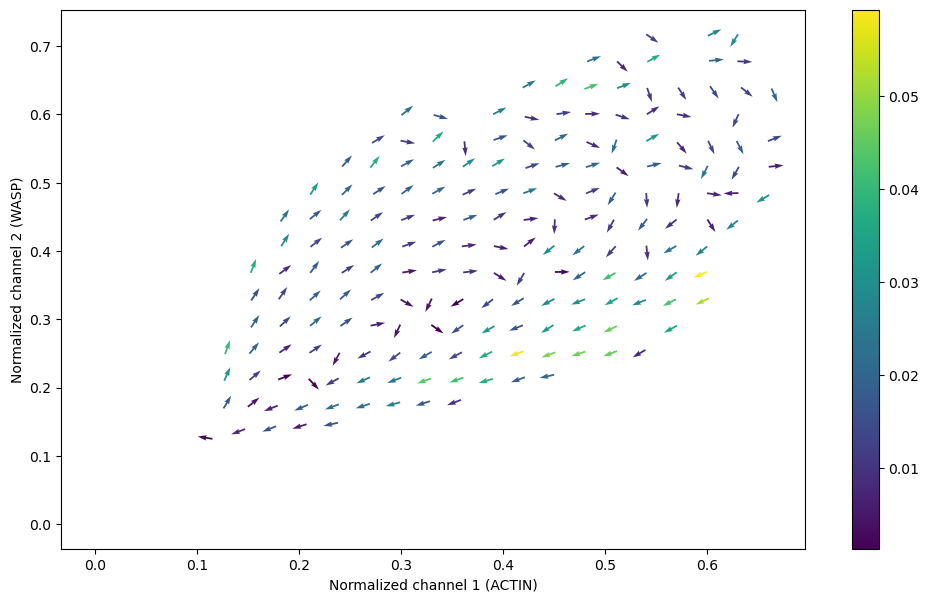

In [50]:
%matplotlib inline

plt.figure(figsize=(12,7))
plot_data = phase_portrait[...].mean()
count_data = phase_portrait[...].count()[val_cols[0]] > 70
x,y = [plot_data[v]*count_data for v in val_cols]
u,v = [plot_data[r]*count_data for r in rate_cols]
mag = np.sqrt(u**2 + v**2)
uu, uv = [i/mag for i in (u,v)]
plt.quiver(x,y,uu,uv,mag,angles='xy',scale=50)
plt.colorbar()
plt.xlabel('Normalized channel 1 (ACTIN)')
plt.ylabel('Normalized channel 2 (WASP)')

plt.savefig(results_dir/"phase_portrait.png")

plt.show()